In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-askga49y
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-askga49y
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=9c0966666ee7f6fdf3a7d76bbfb9d58de48fefba896e7524c3b483aa8528f17d
  Stored in directory: /tmp/pip-ephem-wheel-cache-3fe_024l/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [4]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

0.6.0


In [5]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.3 MB/s eta 0:00:00


In [6]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [7]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [8]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
SAM_ENCODER_VERSION = "vit_h"

In [10]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [11]:
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

# Dataset İndir

Berries Computer Vision Project
https://universe.roboflow.com/utas-bunnk/berries-fyjhd/dataset/5

In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("utas-bunnk").project("berries-fyjhd")
dataset = project.version(5).download("voc")

Honey_bees_dataset Image Dataset
https://universe.roboflow.com/ahmedelmogtaba-ali/honey_bees_dataset/dataset/4

In [12]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()
project = rf.workspace("ahmedelmogtaba-ali").project("honey_bees_dataset")
dataset = project.version(4).download("voc")


/content
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Honey_bees_dataset-4 in voc:: 100%|██████████| 413/413 [00:00<00:00, 2222.72it/s]


In [13]:
dataset.location

'/content/Honey_bees_dataset-4'

In [14]:
object_detection_dataset = sv.Dataset.from_pascal_voc(
    images_directory_path=f"{dataset.location}/train",
    annotations_directory_path=f"{dataset.location}/train"
)
     

In [15]:
import random
random.seed(9001)


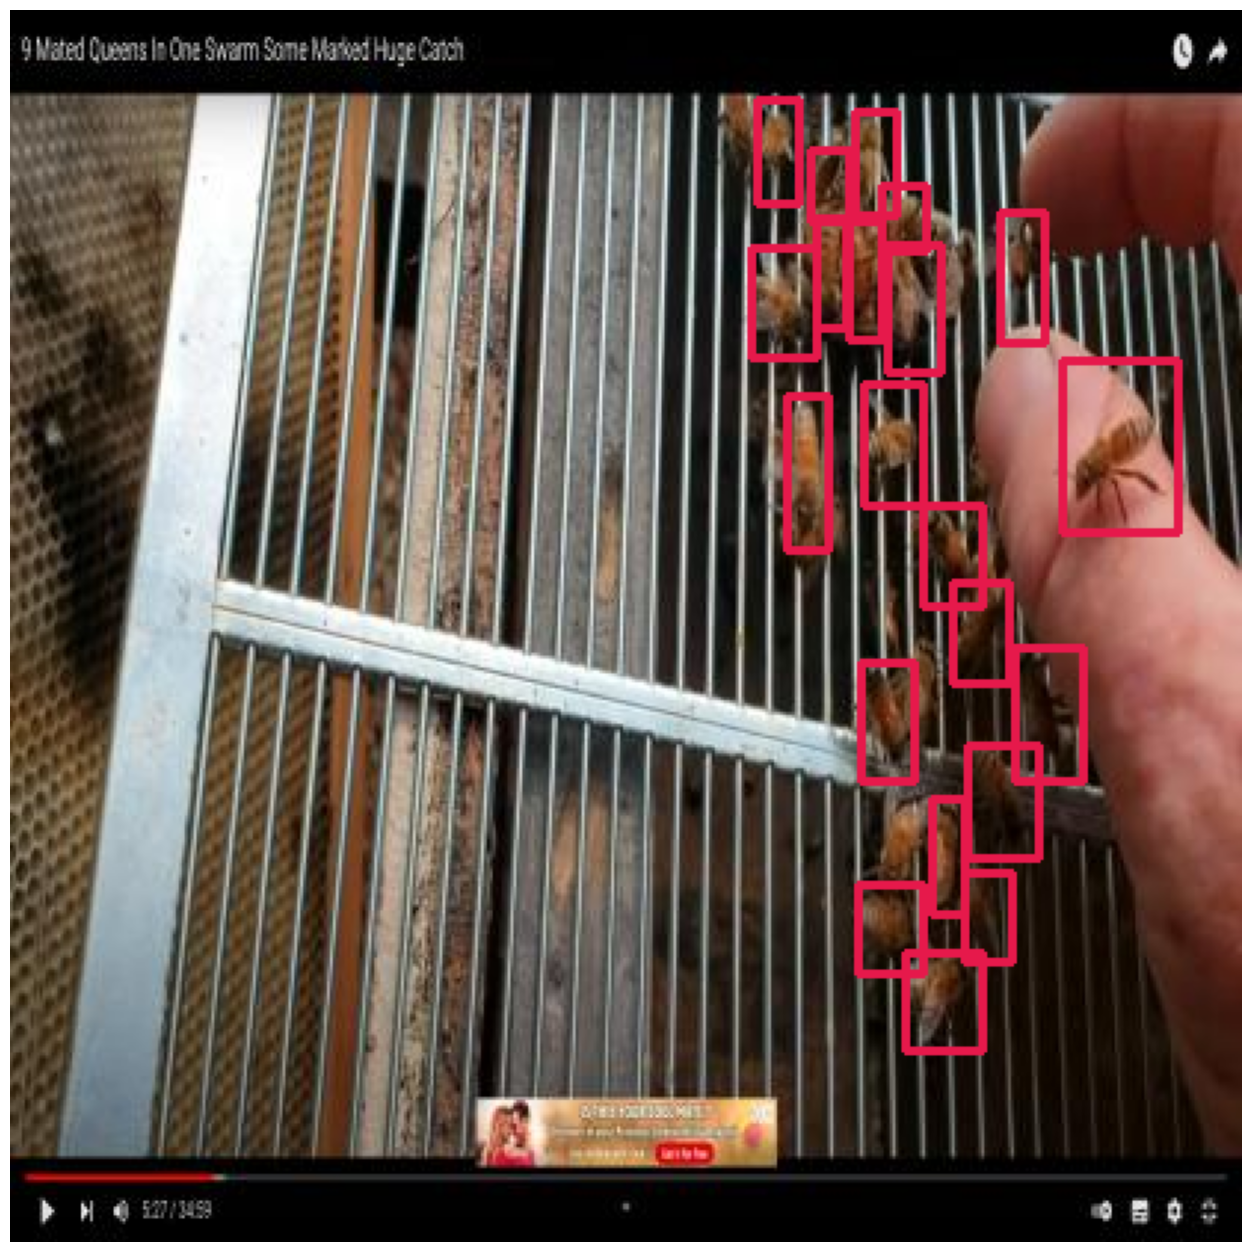

In [16]:
image_names = list(object_detection_dataset.images.keys())
image_name = random.choice(image_names)

image = object_detection_dataset.images[image_name]
detections = object_detection_dataset.annotations[image_name]

box_annotator = sv.BoxAnnotator()

annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, skip_label=True)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

# SAM'i Çalıştır, Kutuları Maskelere Dönüştür

In [17]:
from tqdm.notebook import tqdm
import cv2

for image_name, image in tqdm(object_detection_dataset.images.items()):
    detections = object_detection_dataset.annotations[image_name]
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

  0%|          | 0/143 [00:00<?, ?it/s]

Dönüştürülen veri kümesinden farklı bir görüntüye göz atmak için aşağıdaki hücreyi 👇 yeniden çalıştırın.

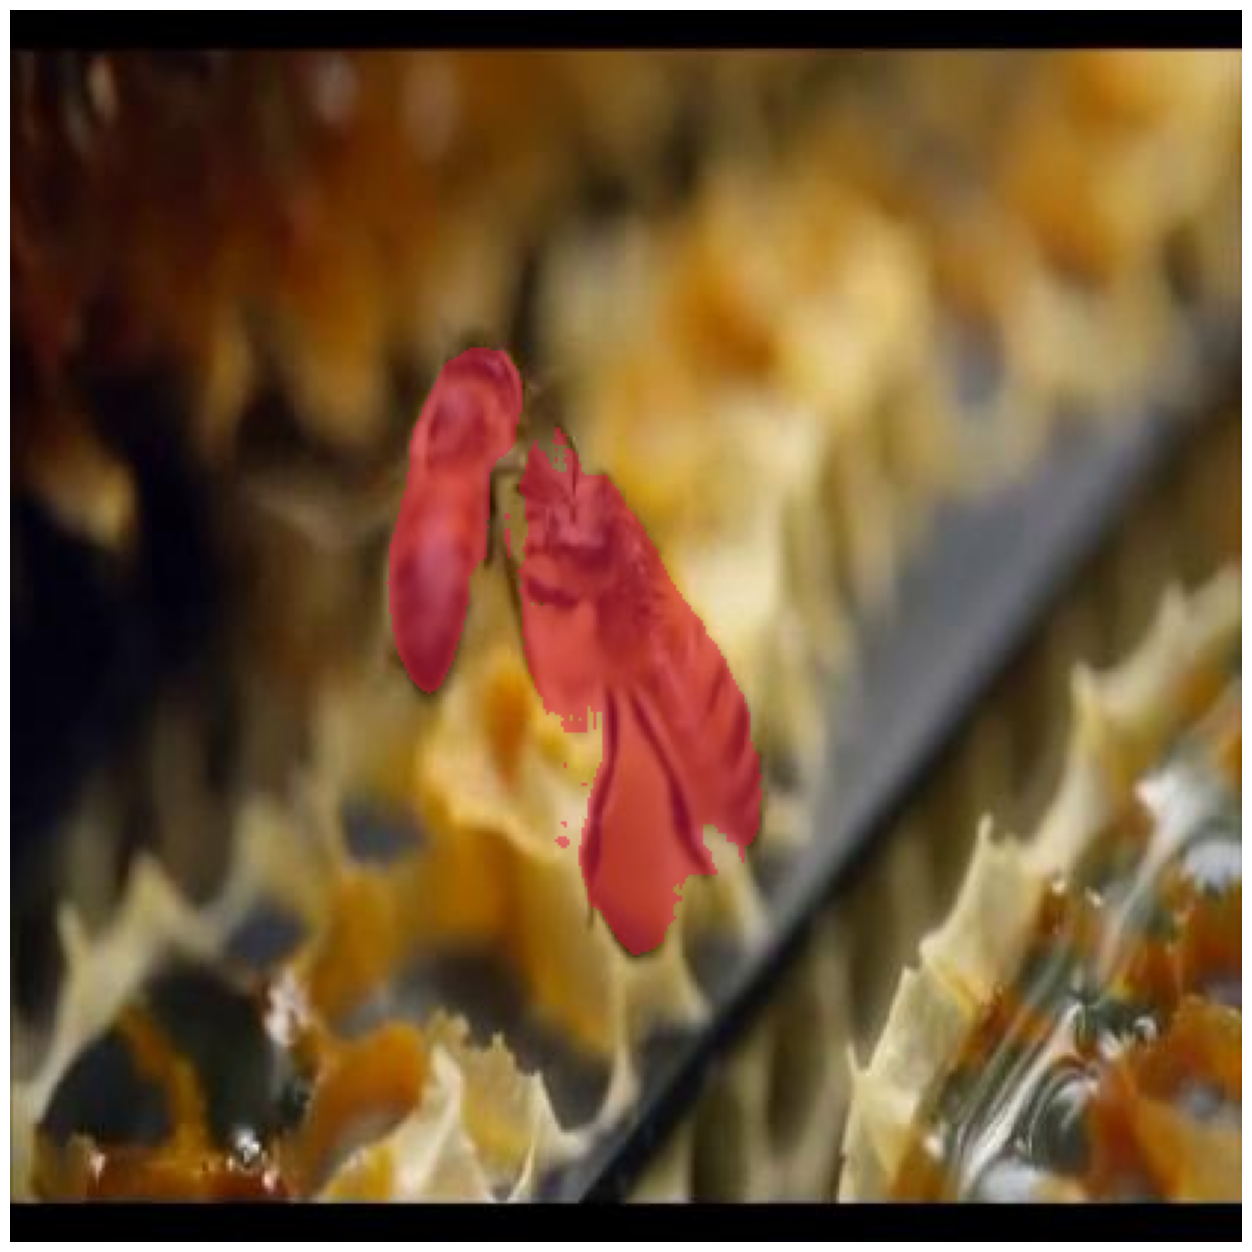

In [18]:
image_names = list(object_detection_dataset.images.keys())
image_name = random.choice(image_names)

image = object_detection_dataset.images[image_name]
detections = object_detection_dataset.annotations[image_name]

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

In [ ]:
print(detections)

# Etiketleri Pascal VOC XML formatında kaydedin
Ek açıklamalarımızı (annotation) Roboflow'a yüklemeden önce, onları sabit diskimize kaydetmemiz gerekir. Bunu yapmak için en son supervision özelliklerinden birini kullanacağız

In [19]:
ANNOTATIONS_DIRECTORY = os.path.join(dataset.location, 'annotations')

MIN_IMAGE_AREA_PERCENTAGE = 0.002
MAX_IMAGE_AREA_PERCENTAGE = 0.80
APPROXIMATION_PERCENTAGE = 0.50

In [20]:
object_detection_dataset.as_pascal_voc(
    annotations_directory_path=ANNOTATIONS_DIRECTORY,
    min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
    max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
    approximation_percentage=APPROXIMATION_PERCENTAGE
)

# Upload annotations to Roboflow

In [27]:
print(dataset.name)

Honey_bees_dataset


In [28]:
dataset.name = "Bal-arilari"

In [30]:
import roboflow
from roboflow import Roboflow

roboflow.login()

workspace = Roboflow().workspace()
new_project = workspace.create_project(
    project_name=dataset.name,
    project_license="MIT",
    project_type="instance-segmentation", 
    annotation=f"{dataset.name}")

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


In [31]:
import os

image_paths = sv.list_files_with_extensions(directory=f"{dataset.location}/train", extensions=["jpg", "jpeg", "png"])
for image_path in tqdm(image_paths):
    image_name = image_path.name
    annotation_name = f"{image_path.stem}.xml"
    image_path = str(image_path)
    annotation_path = os.path.join(ANNOTATIONS_DIRECTORY, annotation_name)
    new_project.upload(
        image_path=image_path, 
        annotation_path=annotation_path, 
        split="train", 
        is_prediction=True, 
        overwrite=True, 
        tag_names=["auto-annotated-with-grounded-sam"],
        batch_name="auto-annotated-with-grounded-sam"
    )

  0%|          | 0/143 [00:00<?, ?it/s]

-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found given annotation file
-> found